# Exploratory Data Analysis

## 0. Environment set up

In [1]:
# Switch to home project directory
%cd ../..

/Users/alejandro.medrano/Projects/UNITE_TALKING_POINTS


/Users/alejandro.medrano/.local/share/virtualenvs/UNITE_TALKING_POINTS-QWuKLflF/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [31]:
import json
import os

import pandas as pd
import numpy as np

import spacy

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr, kendalltau

from bert_score import BERTScorer
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import logging
logging.set_verbosity_error()

from tqdm.notebook import tqdm

from textstat import flesch_reading_ease

from src.unite_talking_points.utils.config.config_loader import ConfigLoader

In [3]:
config = ConfigLoader().load_config(current_directory_is_root=True)

## 1. Data loading

In [4]:
def load_json_data(data_dir):
    """
    Load JSON data from the specified directory into a pandas DataFrame.

    Args:
    - data_dir (str): Path to the directory containing JSON files.

    Returns:
    - df (pd.DataFrame): DataFrame containing the loaded JSON data.
    """
    # Initialize empty lists to store data
    file_names = []
    labels = []
    document_names = []
    meeting_names = []
    meeting_dates = []
    contents = []
    prompts = []

    # Iterate over each JSON file in the directory
    for filename in os.listdir(data_dir):
        if filename.endswith('.json'):
            with open(os.path.join(data_dir, filename), 'r') as file:
                data = json.load(file)
                # Extract data from each JSON file and append to lists
                file_names.append(filename)
                labels.append(data['label'])
                document_names.append(data['document_name'])
                meeting_names.append(data['meeting_name'])
                meeting_dates.append(data['meeting_date'])
                contents.append(data['content'])
                prompts.append(data['prompt'])

    # Create a DataFrame from the lists
    df = pd.DataFrame({
        'file_name': file_names,
        'label': labels,
        'document_name': document_names,
        'meeting_name': meeting_names,
        'meeting_date': meeting_dates,
        'content': contents,
        'prompt': prompts
    })

    return df

In [5]:
df = load_json_data(config['Directories']['raw_data_path'])

In [6]:
df

,file_name,label,document_name,meeting_name,meeting_date,content,prompt
0,PSGD 2023-03-06 Talking Points for USG DOS on ...,ai,Talking Points for USG DOS on Generative AI,Senior Manamement Group,09-03-2023,Generative Artificial Intelligence is a form o...,Generate talking points addressing the recent ...
1,BN DOS USG on Implementation of Digital Transf...,peacekeeping,Briefing Note for USG DOS,Implementation of the Peacekeeping Digital Tra...,01-06-2022,DOS is a partner in the digital transformation...,Create talking points highlighting the partner...
2,2022-12-08 DRAFT Remarks for 7th Pannel ICT Af...,digital_transformation,Remarks for ASG OICT,7th Panel: Information and Communications Tech...,08-12-2022,Acknowledgment of the crucial moment for ICT i...,Create a draft for a keynote address by a UN o...
3,2022-10-14 764 CXOTalk ASG OICT FINAL digital ...,digital_transformation,CITO Interview CXOTalk Show,"CXOTALK EPISODE #764, DIGITAL TECHNOLOGIES & ...",14-10-2022,Role of Technology at the UN: Technology plays...,Generate talking points on how technology inte...
4,2022-08-24 TECH ENVOY TPs - CITO cybersecurity...,cybersecurity,Talking Points for ASG OICT,Meeting with the incoming Special Envoy for Te...,24-09-2022,"Trust in the integrity, reliability and securi...",Generate talking points about the importance o...
5,2022-08-24 TECH ENVOY TPs - CITO ai.json,ai,Talking Points for ASG OICT,Meeting with the incoming Special Envoy for Te...,24-08-2022,Welcome!\nI would very much like to see contin...,Please draft a message welcoming collaboration...
6,2022-03-02 Talking Points for USG DMSPC Our Co...,data_strategy,Talking Points for USG DMSPC - Our Common Agenda,,02-03-2022,OICT continues to support business entities in...,Generate talking points on the ongoing efforts...
7,2023-09-15 Opening Remarks UNGS ScienceSummit ...,data_strategy,Opening Remarks for ASG OICT,UNGA Science Summit,12-09-2023,Emphasis on the importance of science as a cen...,Generate a set of strategic talking points for...
8,SG remarks to the Security Council on Artifici...,ai,SG remarks to the Security Council on Artifici...,SG remarks to the Security Council on Artifici...,01-09-2023,"AI has reached unprecedented speed and reach, ...",Generate a comprehensive overview of the curre...
9,2022-10-14 764 CXOTalk ASG OICT FINAL ict stra...,ict_strategy,CITO Interview CXOTalk Show,"CXOTALK EPISODE #764, DIGITAL TECHNOLOGIES & T...",14-10-2022,Role and Functions of the ICT Office: The Chie...,Generate a detailed overview of the Informatio...


## 2. Basics statistics

In [7]:
# Number of documents
num_documents = len(df)

# Distribution of labels
label_counts = df['label'].value_counts()

# Distribution of meeting names
meeting_counts = df['meeting_name'].value_counts()

# Display basic statistics
print("Basic Statistics:")
print("Number of documents:", num_documents)
print("\nLabel Distribution:")
print(label_counts)
print("\nMeeting Name Distribution:")
print(meeting_counts)

Basic Statistics:
Number of documents: 30

Label Distribution:
label
ai                        7
digital_transformation    6
peacekeeping              5
cybersecurity             4
data_strategy             4
ict_strategy              4
Name: count, dtype: int64

Meeting Name Distribution:
meeting_name
Meeting with the incoming Special Envoy for Technology                                                                    4
New DMSPC video production                                                                                                2
7th Partnership for Technology in Peacekeeping Symposium, Kathmandu, Nepal                                                2
UNGA Science Summit                                                                                                       2
Conversation series: UN Technology Partnership for Digital Transformation                                                 2
6th International Partnership for Technology in Peacekeeping Symposium City 

## 3. Data Preprocessing

In [8]:
# Load the English language model
nlp = spacy.load('en_core_web_trf')

/Users/alejandro.medrano/.local/share/virtualenvs/UNITE_TALKING_POINTS-QWuKLflF/lib/python3.9/site-packages/thinc/shims/pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fe

In [9]:
# Function to preprocess text
def preprocess_text(text):
    # Parse the text with spaCy
    doc = nlp(text)
    
    # Tokenization, removing stop words, punctuation, and lemmatization
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    
    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [10]:
# Apply the preprocessing function to the 'content' column
df['preprocessed_content'] = df['content'].apply(preprocess_text)

# Display the preprocessed content
print("Preprocessed Content:")
print(df['preprocessed_content'].head())

/Users/alejandro.medrano/.local/share/virtualenvs/UNITE_TALKING_POINTS-QWuKLflF/lib/python3.9/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


Preprocessed Content:
0    generative artificial intelligence form ai cre...
1    dos partner digital transformation peacekeepin...
2    acknowledgment crucial moment ict transform wo...
3    role technology un technology play central rol...
4    trust integrity reliability security digital t...
Name: preprocessed_content, dtype: object


In [11]:
df['meeting_date'] = pd.to_datetime(df['meeting_date'], format='%d-%m-%Y')

## 4. Word Frequency Analysis

In [12]:
# Function to calculate word frequencies
def calculate_word_frequencies(text):
    # Split the text into words
    words = text.split()
    
    # Create a pandas Series from the list of words
    word_series = pd.Series(words)
    
    # Count the occurrences of each word
    word_counts = word_series.value_counts()

    return word_counts

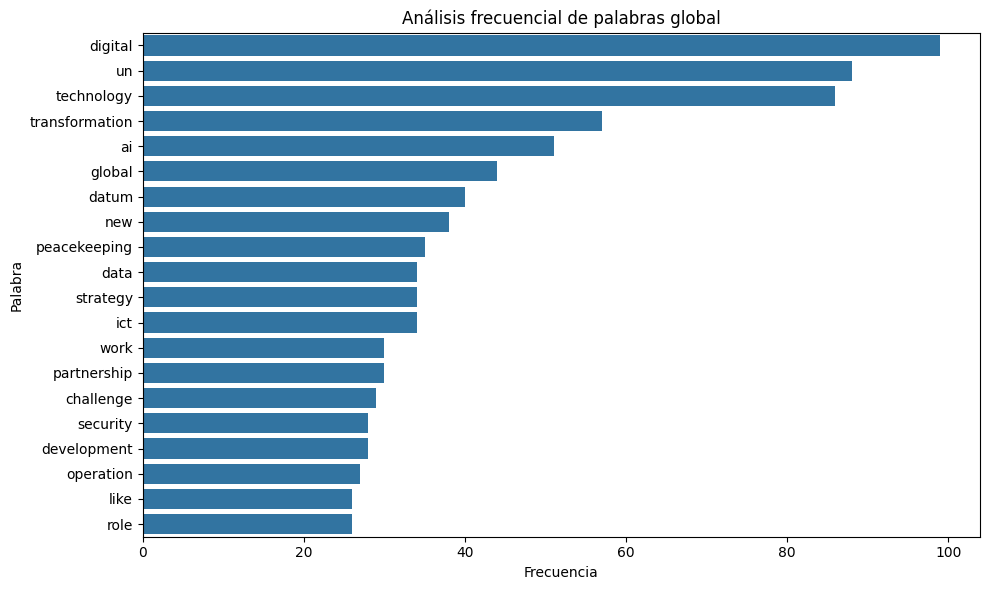

In [13]:
# Concatenate preprocessed content for all labels
all_concatenated_text = ' '.join(df['preprocessed_content'])

# Calculate word frequencies for all labels
all_word_frequencies = calculate_word_frequencies(all_concatenated_text)

# Create a figure and axes for subplots
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

# Plot word frequency analysis for all labels using Seaborn
sns.barplot(x=all_word_frequencies.head(20).values, y=all_word_frequencies.head(20).index, ax=axes)
axes.set_title('Análisis frecuencial de palabras global')
axes.set_xlabel('Frecuencia')
axes.set_ylabel('Palabra')

plt.tight_layout()
plt.savefig('img/frecuencia_global.png')
plt.show()

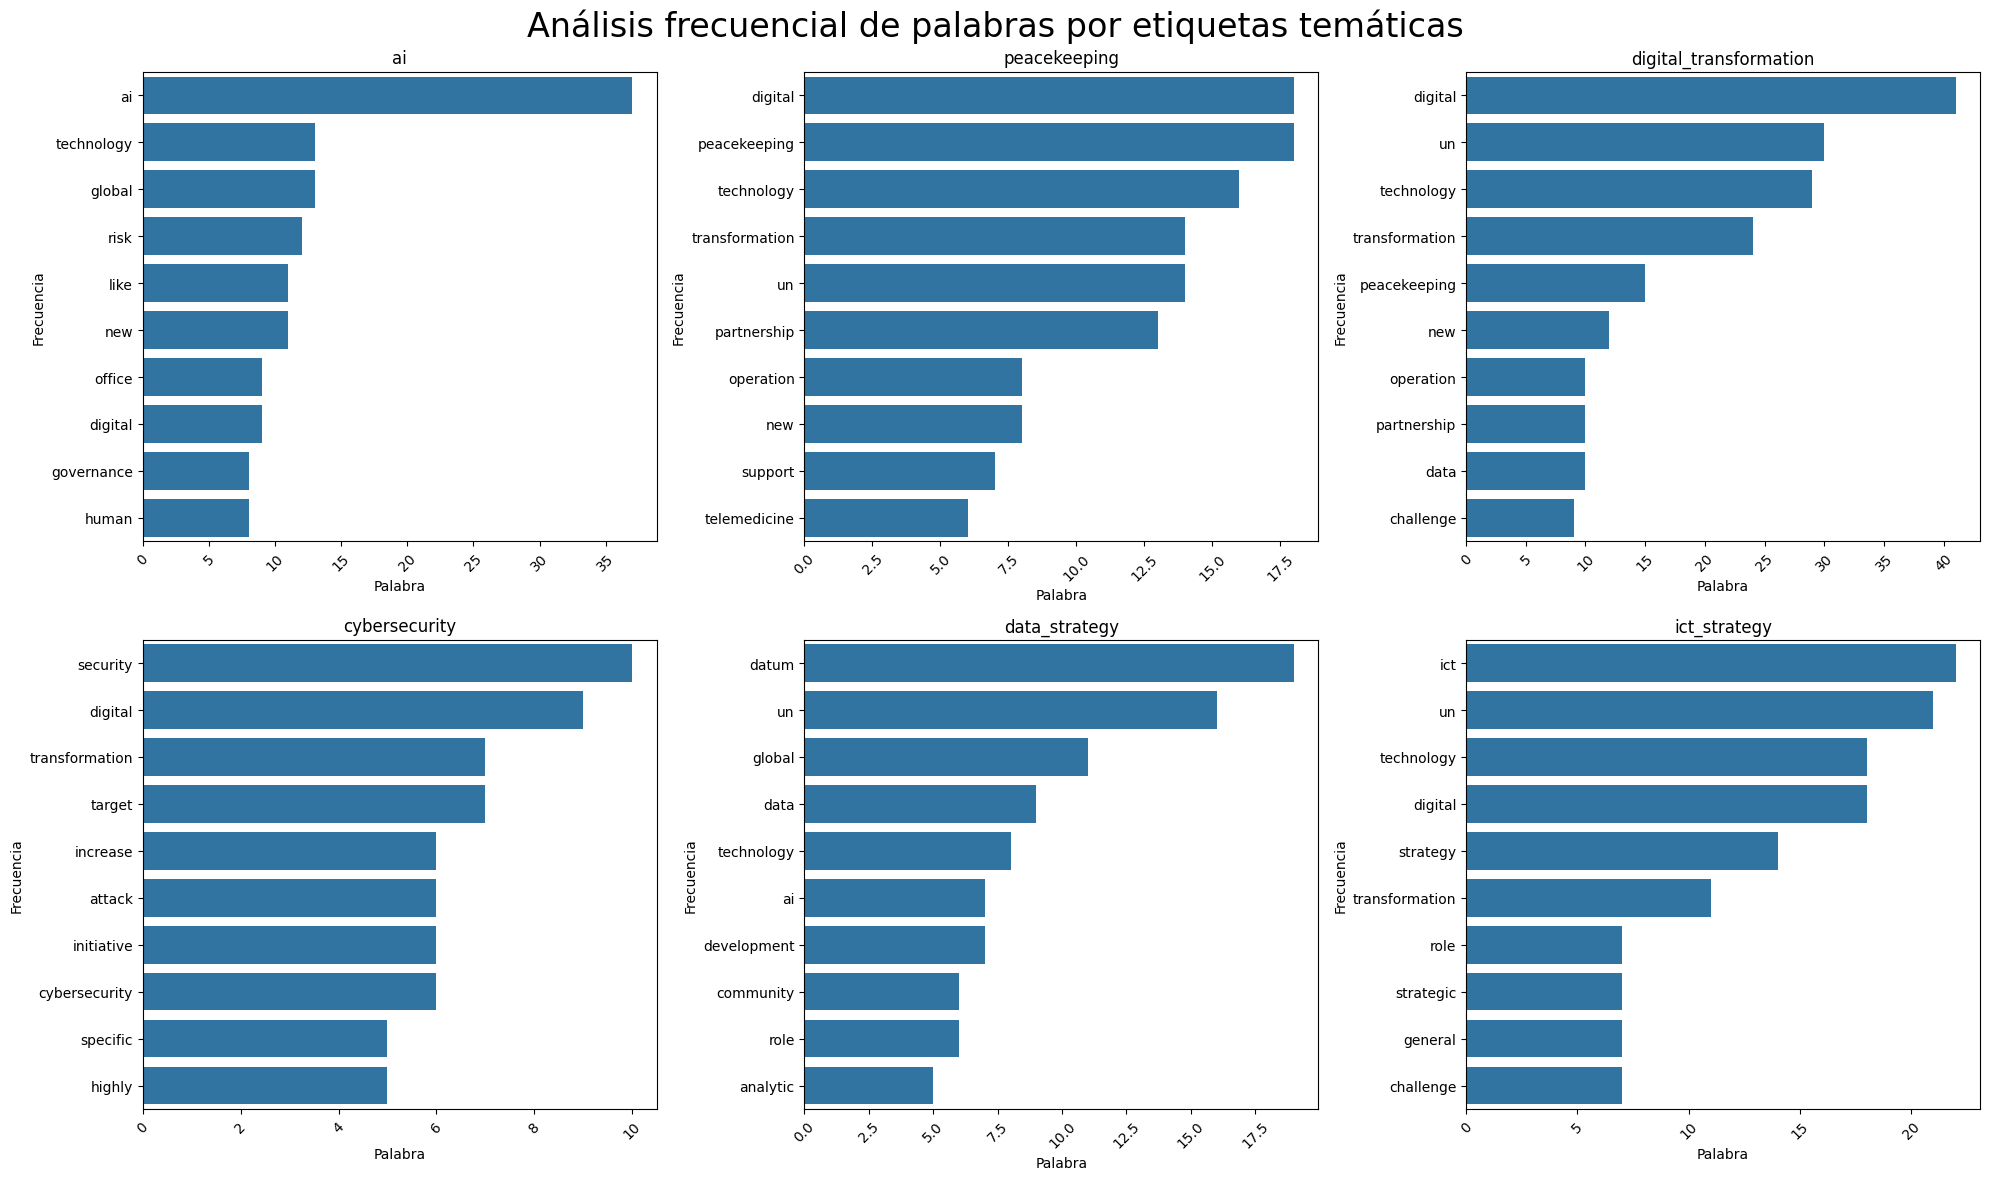

In [14]:
# Calculate word frequencies for each label
word_frequencies_by_label = {}
for label in df['label'].unique():
    # Filter the DataFrame by label
    subset_df = df[df['label'] == label]
    
    # Concatenate preprocessed content of all documents for the label
    concatenated_text = ' '.join(subset_df['preprocessed_content'])
    
    # Calculate word frequencies
    word_frequencies_by_label[label] = calculate_word_frequencies(concatenated_text)

# Create a figure and axes for subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Flatten the axes array to facilitate iteration
axes = axes.flatten()

# Plot word frequency analysis for each label using Seaborn
n = 10
for i, (label, word_freq) in enumerate(word_frequencies_by_label.items()):
    # Plot on the appropriate subplot
    sns.barplot(x=word_freq.head(n).values, y=word_freq.head(n).index, ax=axes[i])
    axes[i].set_title(f'{label}')
    axes[i].set_xlabel('Palabra')
    axes[i].set_ylabel('Frecuencia')
    axes[i].tick_params(axis='x', rotation=45)

# Hide empty subplots
for j in range(len(word_frequencies_by_label), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Análisis frecuencial de palabras por etiquetas temáticas', fontsize=24)
plt.tight_layout()
plt.savefig('img/frecuencia_local.png')
plt.show()

## 5. N-gram Analysis

In [15]:
# Function to calculate n-gram frequencies
def calculate_ngram_frequencies(text, n):
    # Initialize CountVectorizer to extract n-grams
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    
    # Fit and transform the text to extract n-grams
    ngrams = vectorizer.fit_transform([text])
    
    # Get the feature names (n-grams)
    feature_names = vectorizer.get_feature_names_out()
    
    # Get the counts of each n-gram
    ngram_counts = ngrams.toarray().flatten()
    
    # Create a pandas Series from the counts with n-gram names as index
    ngram_freq = pd.Series(ngram_counts, index=feature_names).sort_values(ascending=False)
    
    return ngram_freq

# Function to plot n-gram analysis
def plot_ngram_analysis(ngram_freq, n, label=''):
    plt.figure(figsize=(10, 6))
    ngram_freq.head(20).plot(kind='barh')
    if label:
        plt.title(f'{label}')
    else:
        plt.title(f'Análisis frecuencial global de bigramas')
    plt.xlabel(f'Frecuencia')
    plt.ylabel('Bigrama')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('img/bigramas_global.png')
    plt.show()

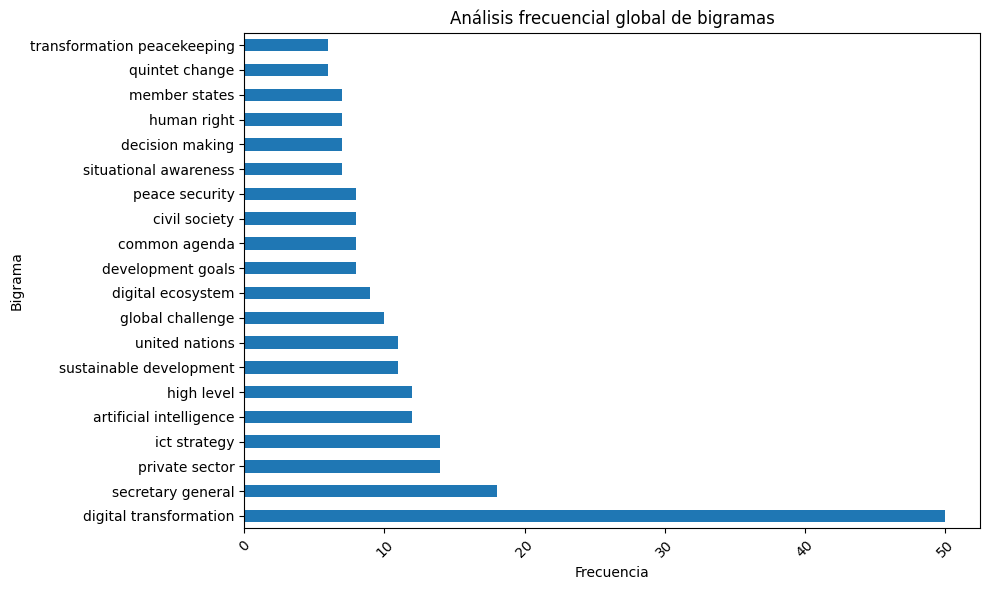

<Figure size 640x480 with 0 Axes>

In [16]:
concatenated_text = ' '.join(df['preprocessed_content'])
ngram_freq = calculate_ngram_frequencies(concatenated_text, n=2)

# Plot N-gram analysis
plot_ngram_analysis(ngram_freq, n=2)
plt.savefig('bigramas_global.png')

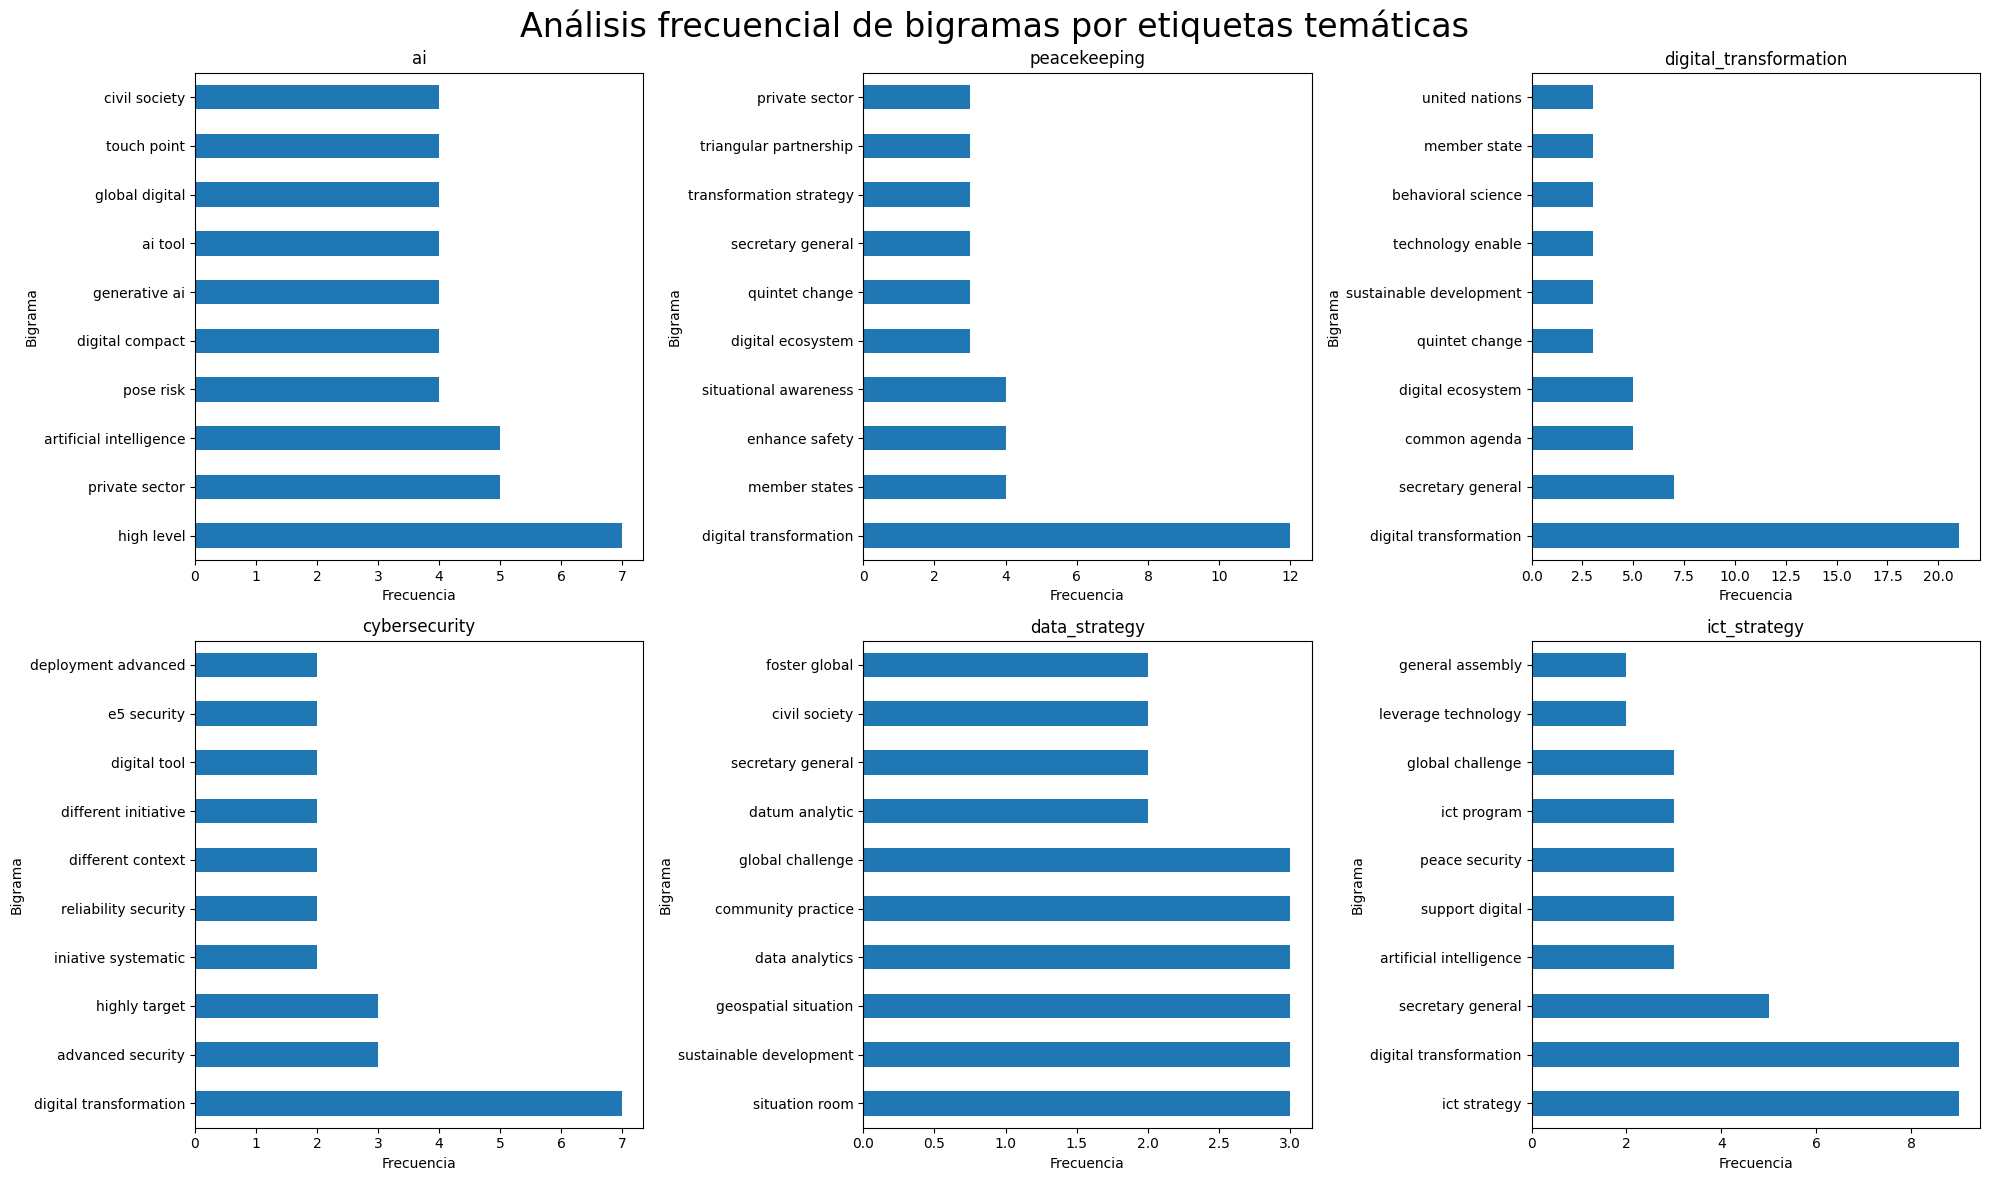

In [17]:
# Perform N-gram analysis for each label
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Flatten the axes array to facilitate iteration
axes = axes.flatten()

for idx, label in enumerate(df['label'].unique()):
    # Filter the DataFrame by label
    subset_df = df[df['label'] == label]
    
    # Concatenate preprocessed content of all documents for the label
    concatenated_text = ' '.join(subset_df['preprocessed_content'])
    
    # Calculate N-gram frequencies for bi-grams (n=2)
    ngram_freq = calculate_ngram_frequencies(concatenated_text, n=2)
    
    # Plot N-gram analysis with rotated orientation on the appropriate subplot
    ax = axes[idx]
    ngram_freq.head(10).sort_values().plot(kind='barh', ax=ax)
    ax.set_title(f'{label}')
    ax.set_xlabel('Frecuencia')
    ax.set_ylabel('Bigrama')
    ax.invert_yaxis()  # Invert y-axis to have highest frequency at the top

# Hide empty subplots
for j in range(len(df['label'].unique()), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Análisis frecuencial de bigramas por etiquetas temáticas', fontsize=24)
plt.tight_layout()
plt.savefig('img/bigrama_local.png')
plt.show()


## 6. Named Entity Recognition Analysis

In [18]:
def perform_ner_with_entities(text):
    # Process the text with spaCy
    doc = nlp(text)
    
    # Initialize defaultdict to count entity occurrences
    entity_counts = defaultdict(int)
    
    # List to store unique entities
    unique_entities = set()
    
    # Iterate over entities in the document
    for ent in doc.ents:
        # Count occurrences of each entity label
        entity_counts[ent.label_] += 1
        
        # Add entity text to unique_entities set
        unique_entities.add((ent.text, ent.label_))
    
    return entity_counts, unique_entities

In [19]:
# Perform NER and extract unique entities for each label
ner_results_by_label = {}
unique_entities_by_label = {}
for label in df['label'].unique():
    # Filter the DataFrame by label
    subset_df = df[df['label'] == label]
    
    # Concatenate preprocessed content of all documents for the label
    concatenated_text = ' '.join(subset_df['preprocessed_content'])
    
    # Perform NER and extract unique entities
    ner_results, unique_entities = perform_ner_with_entities(concatenated_text)
    ner_results_by_label[label] = ner_results
    unique_entities_by_label[label] = unique_entities

# Display NER results and unique entities for each label
for label, ner_results in ner_results_by_label.items():
    #print(f"NER Results for Label: {label}")
    #for ent_label, count in ner_results.items():
    #    print(f"{ent_label}: {count}")
    #print()
    print(f"Unique Entities for Label: {label}")
    for entity, ent_label in unique_entities_by_label[label]:
        print(f"{entity} ({ent_label})")
    print()

/Users/alejandro.medrano/.local/share/virtualenvs/UNITE_TALKING_POINTS-QWuKLflF/lib/python3.9/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


Unique Entities for Label: ai
end year (DATE)
united nations (ORG)
non profit organization (ORG)
facebook (ORG)
5 year (DATE)
microsoft (ORG)
$ 10 $ 15 trillion (MONEY)
week (DATE)
2030 (DATE)
motion picture (PRODUCT)
2024 (DATE)
6 month (DATE)
month (DATE)
artificial intelligence announcement (ORG)
international atomic energy agency (ORG)
google (ORG)
100 million (CARDINAL)
new global entity (ORG)

Unique Entities for Label: peacekeeping
united nations (ORG)
un camp (ORG)
antonio guterres (PERSON)
republic south africa (GPE)
un (ORG)
2021 (DATE)

Unique Entities for Label: digital_transformation
united nations (ORG)
peacekeeping (ORG)
mozambique (GPE)
antonio guterres (PERSON)
2030 (DATE)
17 (CARDINAL)
daily (DATE)
un (ORG)

Unique Entities for Label: cybersecurity
second (ORDINAL)
today (DATE)
law enforcement authority (ORG)
united nations (GPE)
e5 (PRODUCT)
6 (CARDINAL)
approximately 45,000 (CARDINAL)

Unique Entities for Label: data_strategy
artificial intelligence (ORG)
1994 (DATE

## 7. Document Length Distribution

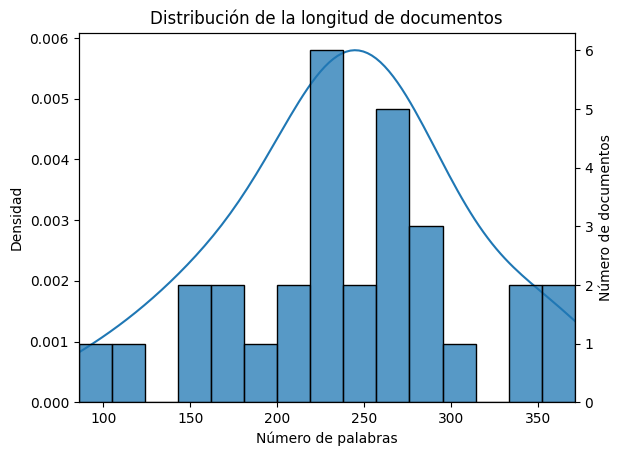

In [21]:
# Calculate document lengths (number of words)
df['document_length'] = df['content'].apply(lambda x: len(x.split()))

fig, ax1 = plt.subplots()
sns.kdeplot(data=df, x="document_length", ax=ax1)

ax1.set_xlim((df["document_length"].min(), df["document_length"].max()))
ax1.set_xlabel('Número de palabras')
ax1.set_ylabel('Densidad')

ax2 = ax1.twinx()
ax2.set_ylabel('Número de documentos')
sns.histplot(data=df, x="document_length", bins=15, ax=ax2)
plt.title('Distribución de la longitud de documentos')
plt.savefig('img/distribucion_longitud.png')
plt.show()

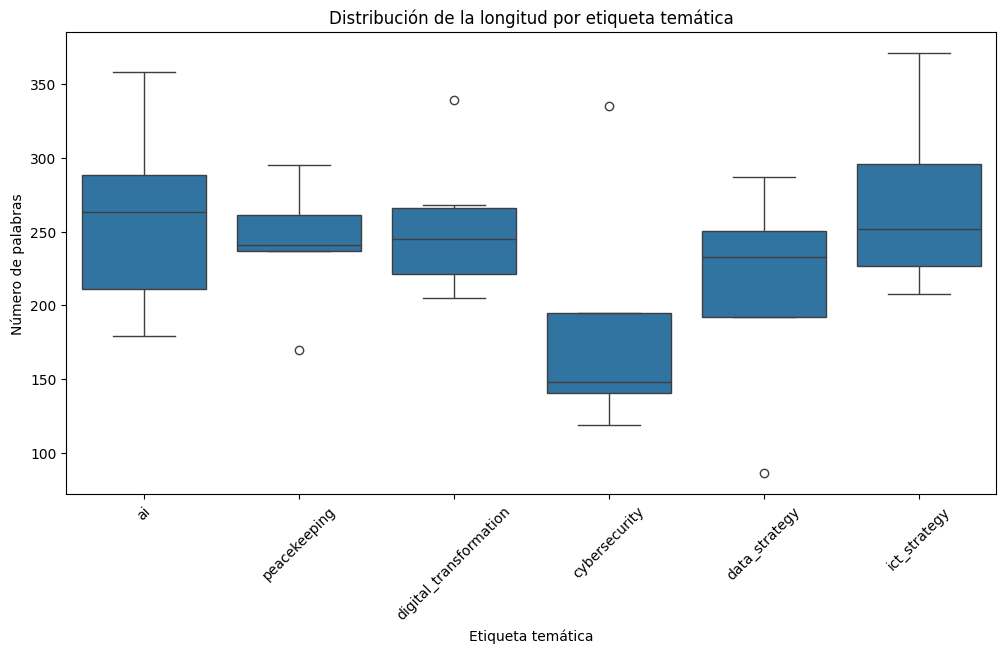

In [23]:
# Plot text length vs. label analysis
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='label', y='document_length')
plt.title('Distribución de la longitud por etiqueta temática')
plt.xlabel('Etiqueta temática')
plt.ylabel('Número de palabras')
plt.xticks(rotation=45)
plt.savefig('img/distribucion_longitud_etiquetas.png')
plt.show()

## 8. Text Similarity Analysis

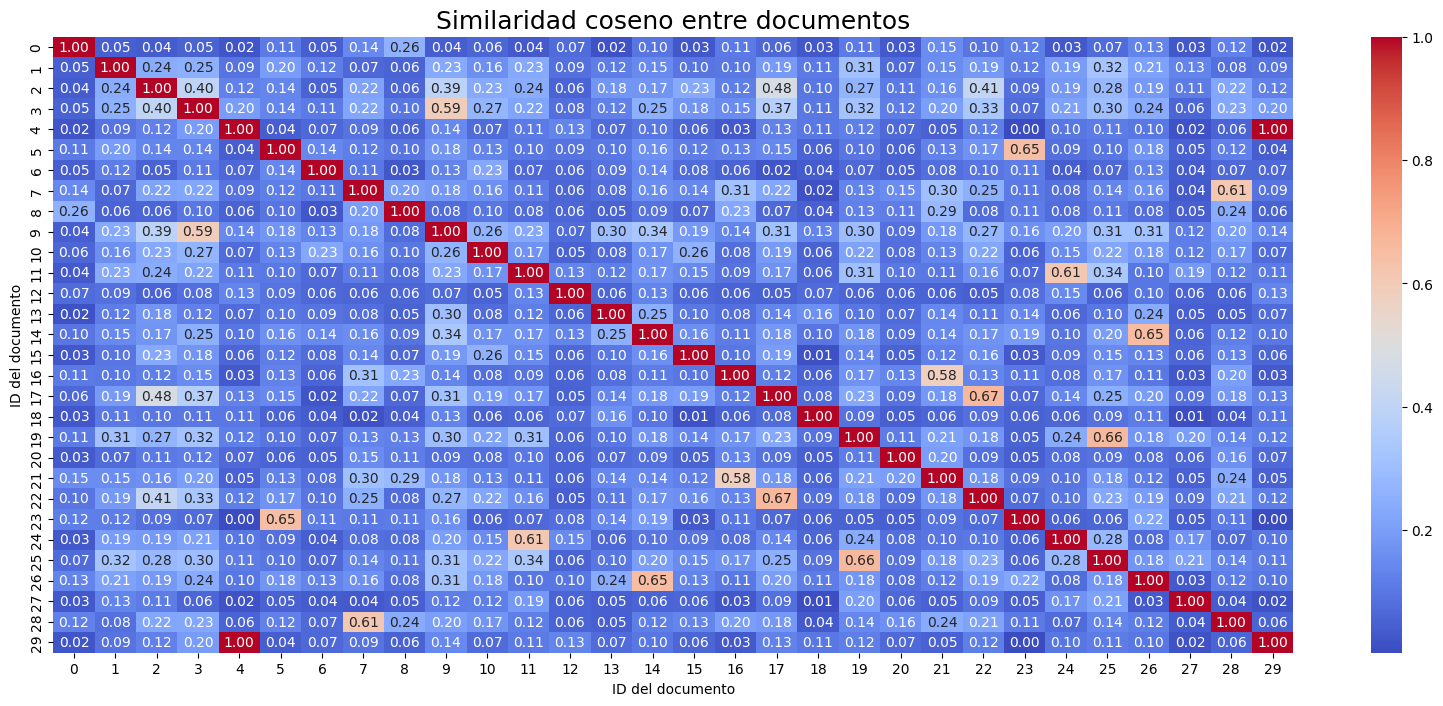

In [55]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit-transform the preprocessed content to create TF-IDF vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(df['preprocessed_content'])

# Compute pairwise cosine similarities between documents
tfidf_cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Plot heatmap of cosine similarities
plt.figure(figsize=(20, 8))
sns.heatmap(tfidf_cosine_similarities, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Similaridad coseno entre documentos', fontsize=18)
plt.xlabel('ID del documento')
plt.ylabel('ID del documento')
plt.savefig('img/similaridad_coseno.png')
plt.show()

In [56]:
# Máscara para excluir la diagonal principal (similaridad de cada documento consigo mismo)
mask = np.ones(tfidf_cosine_similarities.shape, dtype=bool)
np.fill_diagonal(mask, 0)

# Calcula la media de las similitudes de coseno excluyendo la diagonal
mean_cosine_similarity = np.mean(tfidf_cosine_similarities[mask])

print("La media de las similaridades de coseno (excluyendo diagonal) es:", mean_cosine_similarity)

La media de las similaridades de coseno (excluyendo diagonal) es: 0.13957072872539814


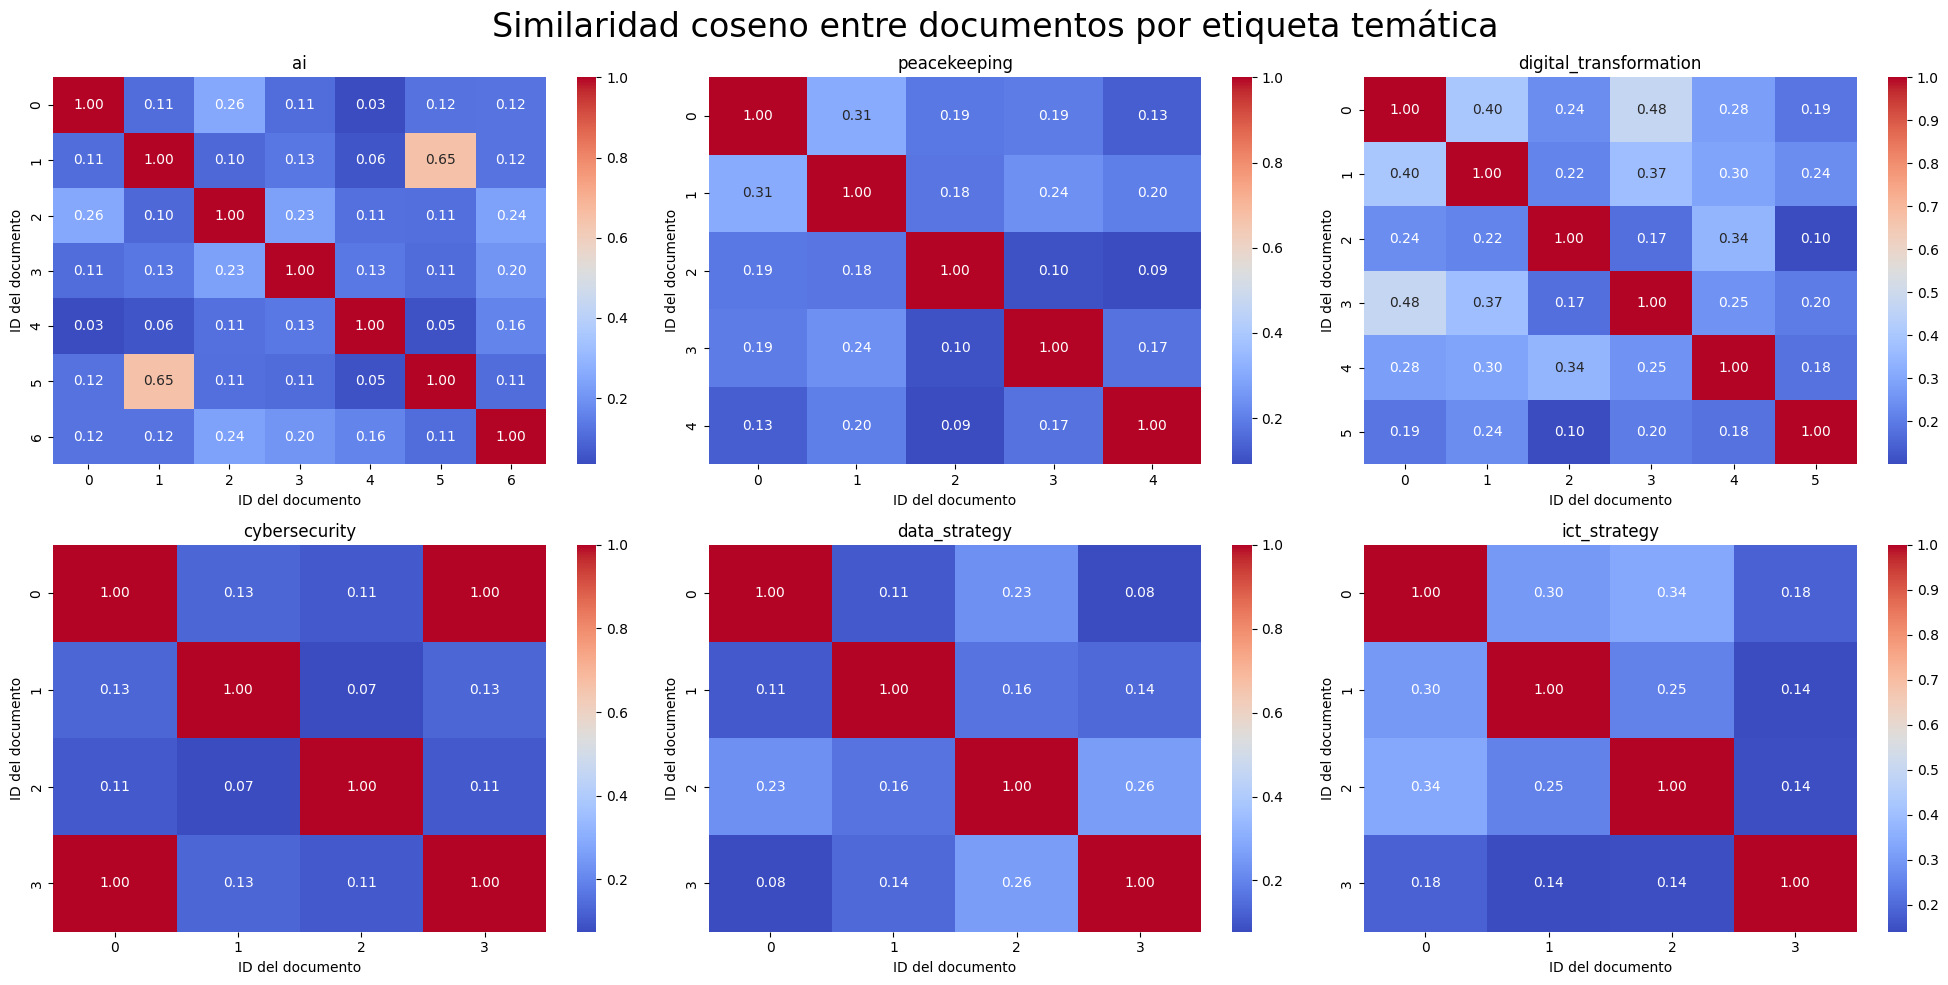

In [57]:
# Get unique labels
unique_labels = df['label'].unique()

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # Adjusted figsize for better fit

# Flatten the axes array to facilitate iteration
axes = axes.flatten()

for idx, label in enumerate(unique_labels):
    # Filter the DataFrame by label
    subset_df = df[df['label'] == label]
    
    # Calculate cosine similarities within label subset
    tfidf_matrix_label = tfidf_vectorizer.transform(subset_df['preprocessed_content'])
    tfidf_cosine_similarities_label = cosine_similarity(tfidf_matrix_label, tfidf_matrix_label)
    
    # Plot heatmap
    ax = axes[idx]
    sns.heatmap(tfidf_cosine_similarities_label, ax=ax, cmap='coolwarm', annot=True, fmt=".2f")
    ax.set_title(f'{label}')
    ax.set_xlabel('ID del documento')
    ax.set_ylabel('ID del documento')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rectangle in tight_layout
plt.suptitle('Similaridad coseno entre documentos por etiqueta temática', fontsize=24, y=0.98)  # Adjust the y position of suptitle
plt.savefig('img/similaridad_coseno_label.png')
plt.show()

In [58]:
# Inicializa una lista para guardar las medias de las similitudes de coseno para cada etiqueta
mean_cosine_similarities_per_label = []

# Itera sobre cada etiqueta única en el DataFrame
for label in df['label'].unique():
    # Filtra el DataFrame por etiqueta
    subset_df = df[df['label'] == label]
    
    # Calcula las similitudes de coseno dentro del subconjunto de la etiqueta
    tfidf_matrix_label = tfidf_vectorizer.transform(subset_df['preprocessed_content'])
    tfidf_cosine_similarities_label = cosine_similarity(tfidf_matrix_label, tfidf_matrix_label)
    
    # Máscara para excluir la diagonal principal
    mask = np.ones(tfidf_cosine_similarities_label.shape, dtype=bool)
    np.fill_diagonal(mask, 0)
    
    # Calcula la media de las similitudes de coseno excluyendo la diagonal
    mean_cosine_similarity = np.mean(tfidf_cosine_similarities_label[mask])
    mean_cosine_similarities_per_label.append(mean_cosine_similarity)

# Calcula la media de las medias de las similitudes de coseno
overall_mean_cosine_similarity = np.mean(mean_cosine_similarities_per_label)

# Imprime las medias de similaridades de coseno para cada etiqueta y la media general
for idx, label in enumerate(df['label'].unique()):
    print(f"Media de similaridad de coseno para la etiqueta '{label}': {mean_cosine_similarities_per_label[idx]}")
print(f"Media general de las medias de similaridades de coseno: {overall_mean_cosine_similarity}")

Media de similaridad de coseno para la etiqueta 'ai': 0.1553985780171556
Media de similaridad de coseno para la etiqueta 'peacekeeping': 0.1805328497925919
Media de similaridad de coseno para la etiqueta 'digital_transformation': 0.262942816020841
Media de similaridad de coseno para la etiqueta 'cybersecurity': 0.25868491168895663
Media de similaridad de coseno para la etiqueta 'data_strategy': 0.16276660332369852
Media de similaridad de coseno para la etiqueta 'ict_strategy': 0.22514016475530155
Media general de las medias de similaridades de coseno: 0.20757765393309088


/Users/alejandro.medrano/.local/share/virtualenvs/UNITE_TALKING_POINTS-QWuKLflF/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

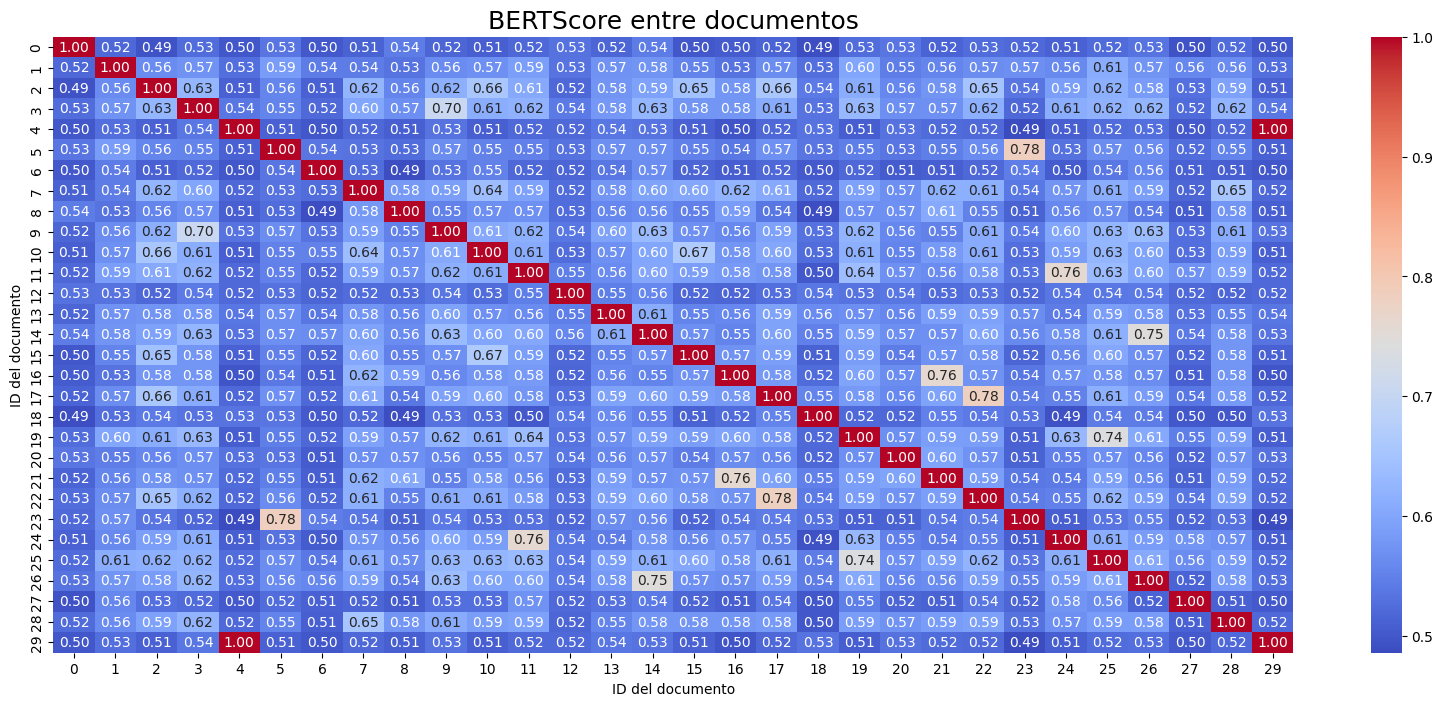

In [62]:
scorer = BERTScorer(model_type='bert-base-uncased')
bert_scores = np.zeros((len(df), len(df)))

for i in tqdm(range(len(df))):
    for j in tqdm(range(i, len(df)), leave=False):  # Compute half the matrix due to symmetry
        P, R, F1 = scorer.score([df['content'][i]], [df['content'][j]], verbose=False)
        bert_scores[i, j] = F1.item()
        bert_scores[j, i] = F1.item()  # Fill both (i, j) and (j, i)

# Plot heatmap of BERTScore similarities
plt.figure(figsize=(20, 8))
sns.heatmap(bert_scores, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('BERTScore entre documentos', fontsize=18)
plt.xlabel('ID del documento')
plt.ylabel('ID del documento')
plt.savefig('img/bert_score.png')
plt.show()

In [63]:
# Máscara para excluir la diagonal principal (similaridad de cada documento consigo mismo)
mask = np.ones(bert_scores.shape, dtype=bool)
np.fill_diagonal(mask, 0)

# Calcula la media de las similitudes bertscore excluyendo la diagonal
mean_bertscore_similarity = np.mean(bert_scores[mask])

print("La media de las similaridades de coseno (excluyendo diagonal) es:", mean_bertscore_similarity)

La media de las similaridades de coseno (excluyendo diagonal) es: 0.5598251763431505


In [64]:
# Función para extraer la parte triangular superior de la matriz sin la diagonal
def get_upper_triangle(matrix):
    return matrix[np.triu_indices_from(matrix, k=1)]

# Aplanar las matrices
flat_bert_scores = get_upper_triangle(bert_scores)
flat_cosine_distances = get_upper_triangle(tfidf_cosine_similarities)

# Calcular correlaciones
pearson_corr, _ = pearsonr(flat_bert_scores, flat_cosine_distances)
spearman_corr, _ = spearmanr(flat_bert_scores, flat_cosine_distances)
kendall_corr, _ = kendalltau(flat_bert_scores, flat_cosine_distances)

print("Correlación de Pearson:", pearson_corr)
print("Correlación de Spearman:", spearman_corr)
print("Correlación de Kendall:", kendall_corr)

Correlación de Pearson: 0.8884533098867187
Correlación de Spearman: 0.8101944264155412
Correlación de Kendall: 0.6201850223065267


## 9. Prompt Similarity Analysis

In [65]:
jaccards = []
for doc, prompt in zip(df['preprocessed_content'], df['prompt']):
    doc_vector = tfidf_vectorizer.transform([doc])
    prompt_vector = tfidf_vectorizer.transform([prompt])
    jaccards.append(cosine_similarity(doc_vector, prompt_vector)[0][0])

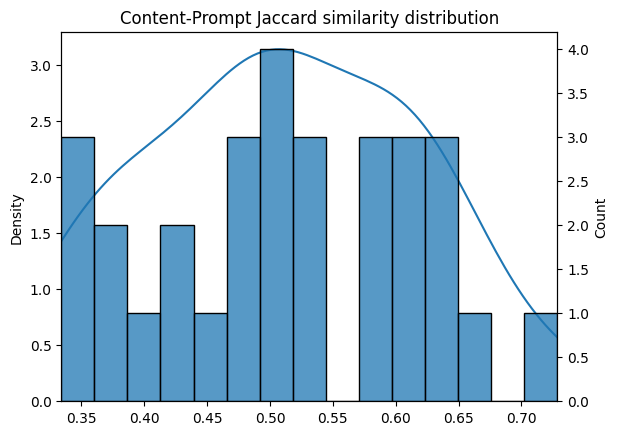

In [66]:
fig, ax1 = plt.subplots()
sns.kdeplot(jaccards, ax=ax1)
ax1.set_xlim((min(jaccards), max(jaccards)))
ax2 = ax1.twinx()
sns.histplot(jaccards, bins=15, ax=ax2)
plt.title('Content-Prompt Jaccard similarity distribution')
plt.xlabel('Jaccard similarity')
plt.show()

In [67]:
bert_scores = []
for doc, prompt in tqdm(zip(df['content'], df['prompt']), total=len(df)):
    P, R, F1 = scorer.score([doc], [prompt], verbose=False)
    bert_scores.append(F1.data.item())

  0%|          | 0/30 [00:00<?, ?it/s]

In [72]:
np.mean(bert_scores)

0.6904254734516144

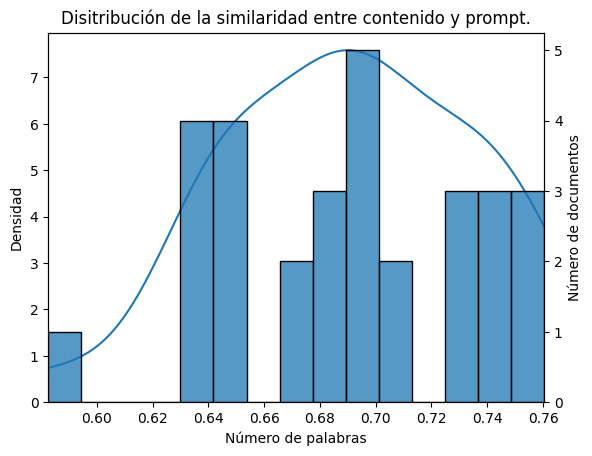

In [73]:
fig, ax1 = plt.subplots()
sns.kdeplot(bert_scores, ax=ax1)
ax1.set_xlim((min(bert_scores), max(bert_scores)))
ax1.set_xlabel('Número de palabras')
ax1.set_ylabel('Densidad')

ax2 = ax1.twinx()
ax2.set_ylabel('Número de documentos')
sns.histplot(bert_scores, bins=15, ax=ax2)
plt.title('Disitribución de la similaridad entre contenido y prompt.')
plt.savefig('img/bertscores_prompt_content.png')
plt.show()

## 10. Fluidity Analysis

In [75]:
# Load pre-trained model and tokenizer
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Function to calculate perplexity
def calculate_perplexity(text):
    encode = tokenizer.encode(text, return_tensors='pt')
    with torch.no_grad():
        loss = model(encode, labels=encode)[0]
    return torch.exp(loss).item()

/Users/alejandro.medrano/.local/share/virtualenvs/UNITE_TALKING_POINTS-QWuKLflF/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [76]:
perplexities = df['content'].apply(lambda x: calculate_perplexity(x))

In [77]:
np.mean(perplexities)

35.35863653818766

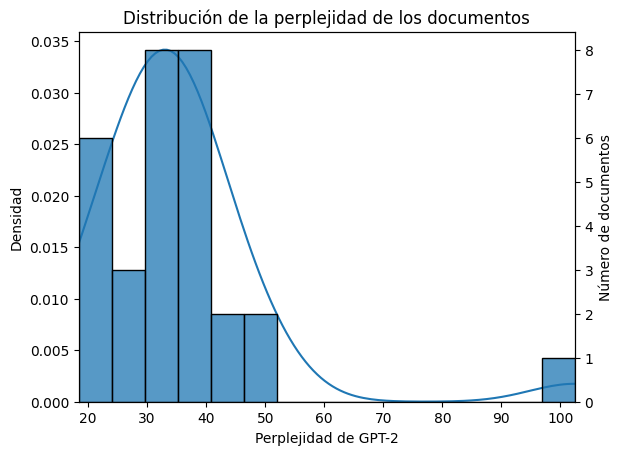

In [82]:
fig, ax1 = plt.subplots()
sns.kdeplot(perplexities, ax=ax1)
ax1.set_xlim((min(perplexities), max(perplexities)))
ax1.set_xlabel('Perplejidad de GPT-2')
ax1.set_ylabel('Densidad')
ax2 = ax1.twinx()
ax2.set_ylabel('Número de documentos')
sns.histplot(perplexities, bins=15, ax=ax2)
plt.title('Distribución de la perplejidad de los documentos')
plt.savefig('img/perplexity.png')
plt.show()

## 11. Readibility Analysis

In [89]:
fleshs = df['content'].apply(lambda x: flesch_reading_ease(x))

In [90]:
np.mean(fleshs)

15.034000000000002

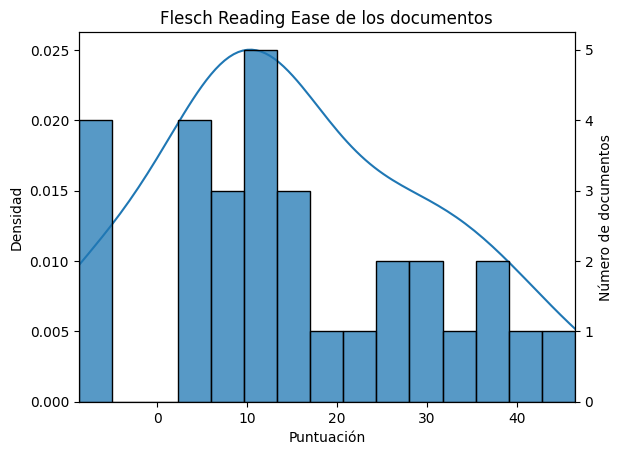

In [93]:
fig, ax1 = plt.subplots()
sns.kdeplot(fleshs, ax=ax1)
ax1.set_xlim((min(fleshs), max(fleshs)))
ax1.set_xlabel('Puntuación')
ax1.set_ylabel('Densidad')
ax2 = ax1.twinx()
ax2.set_ylabel('Número de documentos')
sns.histplot(fleshs, bins=15, ax=ax2)
plt.title('Flesch Reading Ease de los documentos')
plt.xlabel('Flesh score')
plt.savefig('img/flesch.png')
plt.show()

## 12. Date Analysis

In [12]:
df['meeting_date'].describe()

count                     30
mean     2023-01-01 15:12:00
min      2022-02-24 00:00:00
25%      2022-09-07 12:00:00
50%      2022-12-09 00:00:00
75%      2023-05-24 12:00:00
max      2023-09-12 00:00:00
Name: meeting_date, dtype: object

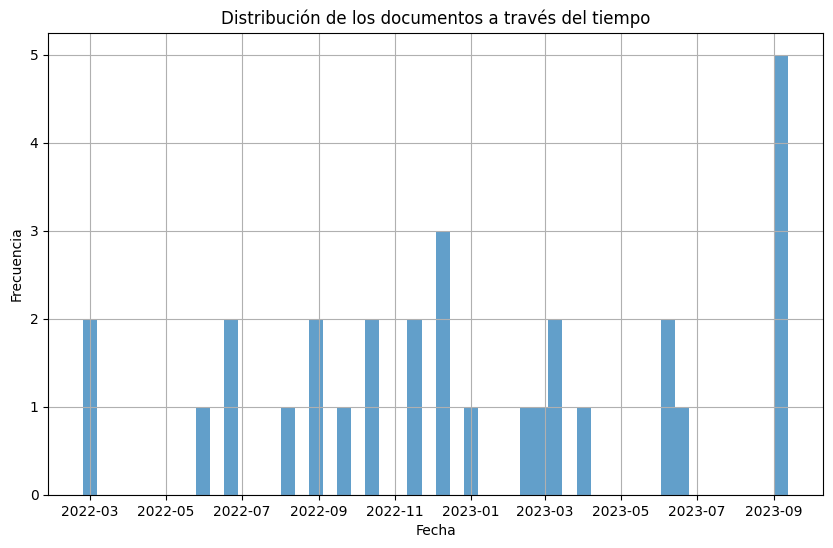

In [18]:
plt.figure(figsize=(10, 6))
df['meeting_date'].hist(bins=50, alpha=0.7)
plt.title('Distribución de los documentos a través del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.savefig('img/fechas.png')
plt.show()

<Figure size 1200x800 with 0 Axes>

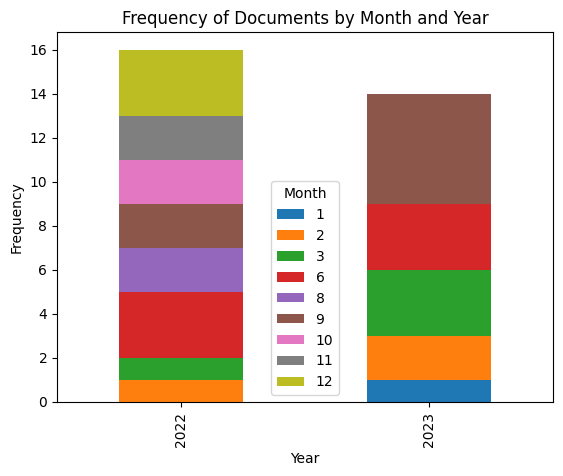

In [36]:
# Extracting month and year
df['year'] = df['meeting_date'].dt.year
df['month'] = df['meeting_date'].dt.month

# Grouping by year and month
monthly_counts = df.groupby(['year', 'month']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(12, 8))
monthly_counts.plot(kind='bar', stacked=True)
plt.title('Frequency of Documents by Month and Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(title='Month')
plt.show()

<Figure size 1200x800 with 0 Axes>

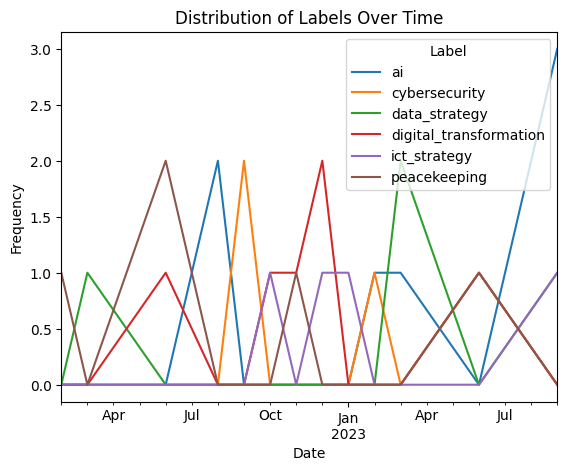

In [37]:
# Grouping by date and label
label_distribution = df.groupby([df['meeting_date'].dt.to_period('M'), 'label']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(12, 8))
label_distribution.plot(kind='line', stacked=False)
plt.title('Distribution of Labels Over Time')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.legend(title='Label')
plt.show()

In [74]:
df.iloc[19]

file_name               2023-06-13 CITO Opening Remarks 7th Symposium ...
label                                                        peacekeeping
document_name            Assistant Secretary-General OICT Opening Remarks
meeting_name            7th Partnership for Technology in Peacekeeping...
meeting_date                                          2023-06-13 00:00:00
content                 Digital Transformation Priority: The symposium...
prompt                  Generate talking points on the digital transfo...
preprocessed_content    digital transformation priority symposium prio...
document_length                                                       237
year                                                                 2023
month                                                                   6
Name: 19, dtype: object

In [69]:
print(df.iloc[25].prompt)

Generate a briefing note outlining the objectives and key themes for an upcoming symposium focused on the digital transformation of peacekeeping operations. The symposium seeks to align with the UN Secretary-General’s vision for a 'UN 2.0,' emphasizing the integration of new and emerging technologies to enhance peacekeeping mandates. Discuss the role of the Office of Information and Communications Technology in adapting to these changes, the potential impacts of Generative AI, and how these technologies can improve peacekeeping effectiveness. Highlight existing digital initiatives and propose new partnerships and technological advancements. Include talking points on the importance of eco-responsibility, telemedicine, and data-driven operations.


In [78]:
print(df.iloc[25].content)

The symposium aims to accelerate the digital transformation of peacekeeping, aligning with the Secretary-General's vision of transforming the UN into a 'UN 2.0.'
Key priorities include: Protecting peacekeepers, Conducting information-driven peace operations, Delivering integrated training and capacity building, Fostering eco-responsibility, Enabling telemedicine
Emphasis on harnessing the power of new and emerging technologies and digital transformation processes to support peacekeeping mandates.
The role of the Office of Information and Communications Technology is to keep pace with rapidly evolving technologies.
The potential of Generative Artificial Intelligence (AI) to disrupt industries is acknowledged, along with the associated risks and the need for regulation.
New technologies can enhance situational awareness in peacekeeping missions, improve decision-making, and minimize environmental impacts.
The digital transformation of peacekeeping is seen as vital for enhancing safety, s

In [60]:
df

,file_name,label,document_name,meeting_name,meeting_date,content,prompt,preprocessed_content,document_length,year,month
0,PSGD 2023-03-06 Talking Points for USG DOS on ...,ai,Talking Points for USG DOS on Generative AI,Senior Manamement Group,2023-03-09,Generative Artificial Intelligence is a form o...,Generate talking points addressing the recent ...,generative artificial intelligence form ai cre...,358,2023,3
1,BN DOS USG on Implementation of Digital Transf...,peacekeeping,Briefing Note for USG DOS,Implementation of the Peacekeeping Digital Tra...,2022-06-01,DOS is a partner in the digital transformation...,Create talking points highlighting the partner...,dos partner digital transformation peacekeepin...,295,2022,6
2,2022-12-08 DRAFT Remarks for 7th Pannel ICT Af...,digital_transformation,Remarks for ASG OICT,7th Panel: Information and Communications Tech...,2022-12-08,Acknowledgment of the crucial moment for ICT i...,Create a draft for a keynote address by a UN o...,acknowledgment crucial moment ict transform wo...,229,2022,12
3,2022-10-14 764 CXOTalk ASG OICT FINAL digital ...,digital_transformation,CITO Interview CXOTalk Show,"CXOTALK EPISODE #764, DIGITAL TECHNOLOGIES & ...",2022-10-14,Role of Technology at the UN: Technology plays...,Generate talking points on how technology inte...,role technology un technology play central rol...,339,2022,10
4,2022-08-24 TECH ENVOY TPs - CITO cybersecurity...,cybersecurity,Talking Points for ASG OICT,Meeting with the incoming Special Envoy for Te...,2022-09-24,"Trust in the integrity, reliability and securi...",Generate talking points about the importance o...,trust integrity reliability security digital t...,148,2022,9
5,2022-08-24 TECH ENVOY TPs - CITO ai.json,ai,Talking Points for ASG OICT,Meeting with the incoming Special Envoy for Te...,2022-08-24,Welcome!\nI would very much like to see contin...,Please draft a message welcoming collaboration...,welcome \n like continue collaboration office ...,263,2022,8
6,2022-03-02 Talking Points for USG DMSPC Our Co...,data_strategy,Talking Points for USG DMSPC - Our Common Agenda,,2022-03-02,OICT continues to support business entities in...,Generate talking points on the ongoing efforts...,oict continue support business entity implemen...,86,2022,3
7,2023-09-15 Opening Remarks UNGS ScienceSummit ...,data_strategy,Opening Remarks for ASG OICT,UNGA Science Summit,2023-09-12,Emphasis on the importance of science as a cen...,Generate a set of strategic talking points for...,emphasis importance science central theme upco...,238,2023,9
8,SG remarks to the Security Council on Artifici...,ai,SG remarks to the Security Council on Artifici...,SG remarks to the Security Council on Artifici...,2023-09-01,"AI has reached unprecedented speed and reach, ...",Generate a comprehensive overview of the curre...,ai reach unprecedented speed reach akin rapid ...,235,2023,9
9,2022-10-14 764 CXOTalk ASG OICT FINAL ict stra...,ict_strategy,CITO Interview CXOTalk Show,"CXOTALK EPISODE #764, DIGITAL TECHNOLOGIES & T...",2022-10-14,Role and Functions of the ICT Office: The Chie...,Generate a detailed overview of the Informatio...,role function ict office chief information tec...,371,2022,10


In [61]:
print(df.iloc[22].content)

The digital transformation conversation aims to create a collaborative path where the private sector, governments, and the United Nations can work together.
The speaker acknowledged the complexity of forming partnerships with the private sector due to different languages and operational approaches but emphasized the successful collaborations during the pandemic with over 26 companies partnering with the WHO.
The UN aspires to integrate its values and principles into digital ecosystems, viewing these platforms as new, borderless communities that require governance beyond national legislations to uphold peace, human rights, and sustainable development goals.
Secretary-General Antonio Guterres's Common Agenda provides a roadmap emphasizing global cooperation and the central role of partnerships in pursuing a better future.
The UN seeks to harness ongoing digitalization to transform its operations, aiming to increase its presence and relevance in new digital ecosystems.
The transformation 